# 青空文庫の感情分析

In [8]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

## データ取得

* 以下のサイトより青空文庫のテキストデータを取得する
  * https://github.com/aozorahack/aozorabunko_text

* 上のサイトの「README.md」より抜粋
  * 青空文庫( https://www.aozora.gr.jp )のサーバ内にある青空文庫形式のテキストのみをテキスト式のまま集めたものです。

In [2]:
!wget https://github.com/aozorahack/aozorabunko_text/archive/master.zip

--2023-05-11 13:00:23--  https://github.com/aozorahack/aozorabunko_text/archive/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/aozorahack/aozorabunko_text/zip/refs/heads/master [following]
--2023-05-11 13:00:23--  https://codeload.github.com/aozorahack/aozorabunko_text/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.121
Connecting to codeload.github.com (codeload.github.com)|192.30.255.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [       <=>          ] 252.57M  6.51MB/s    in 42s     

2023-05-11 13:01:05 (6.06 MB/s) - ‘master.zip’ saved [264836391]



In [3]:
!unzip master.zip

Streaming output truncated to the last 5000 lines.
   creating: aozorabunko_text-master/cards/001585/files/54220_txt_54010/
  inflating: aozorabunko_text-master/cards/001585/files/54220_txt_54010/54220_txt_54010.txt  
   creating: aozorabunko_text-master/cards/001585/files/54221_ruby_54009/
  inflating: aozorabunko_text-master/cards/001585/files/54221_ruby_54009/54221_ruby_54009.txt  
   creating: aozorabunko_text-master/cards/001585/files/54222_txt_54014/
  inflating: aozorabunko_text-master/cards/001585/files/54222_txt_54014/54222_txt_54014.txt  
   creating: aozorabunko_text-master/cards/001585/files/54223_ruby_54015/
  inflating: aozorabunko_text-master/cards/001585/files/54223_ruby_54015/54223_ruby_54015.txt  
   creating: aozorabunko_text-master/cards/001585/files/54224_txt_54149/
  inflating: aozorabunko_text-master/cards/001585/files/54224_txt_54149/54224_txt_54149.txt  
   creating: aozorabunko_text-master/cards/001585/files/54225_txt_54148/
  inflating: aozorabunko_text-maste

In [ ]:
# 必要に応じてフォルダ削除
# !rm -rf bunko

In [4]:
# フォルダ名を変更する
!mv aozorabunko_text-master bunko

In [5]:
os.getcwd()

'/content'

In [25]:
CARD_DIR = f'{os.getcwd()}/bunko/cards'
CARD_DIR

'/content/bunko/cards'

In [7]:
# 全てのテキストファイルを files 以下に移動しておく
for author in os.listdir(CARD_DIR):
    target_folder = f'{CARD_DIR}/{author}/files'
    for file_path in (glob.glob(f'{CARD_DIR}/{author}/**/*.txt', recursive=True)):
        file = file_path.split('/')[-1]
        target_path = f'{target_folder}/{file}'
        if os.path.isfile(target_path):
            print(f'file exists: {target_path}')
        else:
            print(f'{file_path} -> {target_path}')
            shutil.move(file_path, target_folder)
    # フォルダ削除処理
    for f in os.listdir(target_folder):
        sub_folder = f'{target_folder}/{f}'
        if os.path.isdir(sub_folder):
            file_num = sum(os.path.isfile(f'{sub_folder}/{name}') for name in os.listdir(sub_folder))
            if file_num == 0:
                print(f'remove dir: {sub_folder}')
                os.removedirs(sub_folder)

Streaming output truncated to the last 5000 lines.
remove dir: /content/bunko/cards/001399/files/49933_ruby_48499
remove dir: /content/bunko/cards/001399/files/49925_ruby_48352
remove dir: /content/bunko/cards/001399/files/49929_ruby_48253
remove dir: /content/bunko/cards/001399/files/49931_ruby_48021
remove dir: /content/bunko/cards/001399/files/49932_ruby_47849
remove dir: /content/bunko/cards/001399/files/49924_ruby_47791
/content/bunko/cards/001055/files/45685_txt_27768/45685_txt_27768.txt -> /content/bunko/cards/001055/files/45685_txt_27768.txt
/content/bunko/cards/001055/files/47095_ruby_40798/47095_ruby_40798.txt -> /content/bunko/cards/001055/files/47095_ruby_40798.txt
/content/bunko/cards/001055/files/44905_txt_20371/44905_txt_20371.txt -> /content/bunko/cards/001055/files/44905_txt_20371.txt
/content/bunko/cards/001055/files/43795_txt_17946/43795_txt_17946.txt -> /content/bunko/cards/001055/files/43795_txt_17946.txt
/content/bunko/cards/001055/files/4992_ruby_17194/4992_ruby_

## データクレンジング

青空文庫データのクレンジングについては以下のサイトを参考に修正しています．
* [Pythonで青空文庫データを自然言語処理向けにさくっと一括テキスト整形＋前処理](https://qiita.com/dzbt_dzbt/items/593dbd698a07c12a771c)

### クレンジング用関数定義

In [8]:
class ClenseAozoraText:

    def __init__(self, card_dir, author_id, author_name):
        self.card_dir = card_dir        # cardsフォルダへのパス
        self.author_id = author_id      # 青空文庫の作家番号
        self.author_name = author_name  # 青空文庫の表記での作家名

        self.write_title = False        # 2カラム目に作品名を入れるか
        self.write_header = True        # 1行目をカラム名にするか（カラム名「text」「title」）
        self.save_utf8_org = True       # 元データをUTF-8にしたテキストファイルを保存するか
        self.split_kuten = True         # 句点「。」で分割するか

        self.out_dir = Path(f'{self.card_dir}/{self.author_id}/files/')  # ファイル出力先
        self.tx_org_dir = Path(self.out_dir / './org/')  # 元テキストのUTF-8変換ファイルの保存先
        self.tx_edit_dir = Path(self.out_dir / './edit/')  # テキスト整形後のファイル保存先
        self.tx_score_dir = Path(self.out_dir / './score/') # スコア付与したファイルの保存先(作成のみ)
    
    # DataFrameで渡されたテキストデータをクレンジングする
    def text_cleanse_df(self, df):
        # 本文の先頭を探す（'---…'区切りの直後から本文が始まる前提）
        head_tx = list(df[df['text'].str.contains(
            '-------------------------------------------------------')].index)
        # 本文の末尾を探す（'底本：'の直前に本文が終わる前提）
        atx = list(df[df['text'].str.contains('底本：')].index)
        if head_tx == []:
            # もし'---…'区切りが無い場合は、作家名の直後に本文が始まる前提
            head_tx = list(df[df['text'].str.contains(self.author_name)].index)
            head_tx_num = head_tx[0]+1
        else:
            # 2個目の'---…'区切り直後から本文が始まる
            head_tx_num = head_tx[1]+1
        df_e = df[head_tx_num:atx[0]]
        
        # 句点で分割
        if self.split_kuten:
            # df.assign(コメント=df['コメント'].str.split(r'(?<=。)(?=..)')).explode('コメント')
            df_e = df_e.assign(text=df['text'].str.split(r'(?<=。)(?=..)')).explode('text')

        # 青空文庫の書式削除
        df_e = df_e.replace({'text': {'《.*?》': ''}}, regex=True)
        df_e = df_e.replace({'text': {'［.*?］': ''}}, regex=True)
        df_e = df_e.replace({'text': {'｜': ''}}, regex=True)

        # 字下げ（行頭の全角スペース）を削除
        df_e = df_e.replace({'text': {'　': ''}}, regex=True)

        # 節区切りを削除
        df_e = df_e.replace({'text': {'^.$': ''}}, regex=True)
        df_e = df_e.replace({'text': {'^―――.*$': ''}}, regex=True)
        df_e = df_e.replace({'text': {'^＊＊＊.*$': ''}}, regex=True)
        df_e = df_e.replace({'text': {'^×××.*$': ''}}, regex=True)

        # 記号、および記号削除によって残ったカッコを削除
        # df_e = df_e.replace({'text': {'―': ''}}, regex=True)
        # df_e = df_e.replace({'text': {'…': ''}}, regex=True)
        # df_e = df_e.replace({'text': {'※': ''}}, regex=True)
        df_e = df_e.replace({'text': {'「」': ''}}, regex=True)

        # 一文字以下で構成されている行を削除
        df_e['length'] = df_e['text'].map(lambda x: len(x))
        df_e = df_e[df_e['length'] > 1]

        # インデックスがずれるので振りなおす
        df_e = df_e.reset_index().drop(['index'], axis=1)

        # 空白行を削除する（念のため）
        df_e = df_e[~(df_e['text'] == '')]

        # インデックスがずれるので振り直し、文字の長さの列を削除する
        df_e = df_e.reset_index().drop(['index', 'length'], axis=1)
        return df_e

    # クレンジングされたデータを保存する
    def save_cleanse_text(self, target_file):
        try:
            # ファイルの読み込み
            print(target_file)
            # Pandas DataFrameとして読み込む（cp932で読み込まないと異体字が読めない）
            df_tmp = pd.read_csv(target_file, encoding='cp932', names=['text'])
            # 元データをUTF-8に変換してテキストファイルを保存
            if self.save_utf8_org:
                out_org_file_nm = Path(target_file.stem + '.tsv')
                df_tmp.to_csv(Path(self.tx_org_dir / out_org_file_nm), sep='\t',
                            encoding='utf-8', index=None)
            # テキスト整形
            df_tmp_e = self.text_cleanse_df(df_tmp)
            if self.write_title:
                # タイトル列を作る
                df_tmp_e['title'] = df_tmp['text'][0]
            out_edit_file_nm = Path(target_file.stem + '.txt')
            df_tmp_e.to_csv(Path(self.tx_edit_dir / out_edit_file_nm), sep='\t',
                            encoding='utf-8', index=None, 
                            header=self.write_header)
        except Exception as e:
            print(f'ERROR: {target_file}, {str(e)}')
    
    def exec(self):
        # zipファイルのリストを作成
        zip_list = list(self.out_dir.glob('*.txt'))
        # 保存ディレクトリを作成しておく
        self.tx_edit_dir.mkdir(exist_ok=True, parents=True)
        self.tx_score_dir.mkdir(exist_ok=True, parents=True)
        if self.save_utf8_org:
            self.tx_org_dir.mkdir(exist_ok=True, parents=True)

        for i, target_file in enumerate(zip_list):
            self.save_cleanse_text(target_file)

### データクレンジング実行

In [1]:
author_list = [
    ['000148', '夏目漱石'],
    ['001779', '江戸川乱歩'],
    ['001044', 'マリー・ルイーズ・ド・ラ・ラメー'],
    ['000081', '宮沢賢治']
]

In [10]:
for id, name in author_list:
    print(f'-- {id}:{name} --')
    cl = ClenseAozoraText(CARD_DIR, id, name)
    cl.exec()

-- 000148:夏目漱石 --
/content/bunko/cards/000148/files/798_ruby_2413.txt
/content/bunko/cards/000148/files/784_ruby.txt
/content/bunko/cards/000148/files/764_ruby_2927.txt
/content/bunko/cards/000148/files/762_ruby_1705.txt
/content/bunko/cards/000148/files/2372_ruby_2074.txt
/content/bunko/cards/000148/files/755_ruby_3617.txt
ERROR: /content/bunko/cards/000148/files/755_ruby_3617.txt, Error tokenizing data. C error: Expected 1 fields in line 81, saw 3

/content/bunko/cards/000148/files/753_ruby_1701.txt
/content/bunko/cards/000148/files/58842_ruby_76723.txt
ERROR: /content/bunko/cards/000148/files/58842_ruby_76723.txt, Error tokenizing data. C error: Expected 1 fields in line 2258, saw 4

/content/bunko/cards/000148/files/2680_ruby_6345.txt
/content/bunko/cards/000148/files/775_txt.txt
ERROR: /content/bunko/cards/000148/files/775_txt.txt, Error tokenizing data. C error: Expected 1 fields in line 2865, saw 2

/content/bunko/cards/000148/files/791_ruby_1549.txt
/content/bunko/cards/000148/

## 感情分析

### 必要なライブラリの取得

In [9]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.9 MB/s eta 0:00:00


In [11]:
!pip install fugashi ipadic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 49.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556703 sha256=090cbab4c2255faca0a5aede77c9ae195506a57a4193bb8cd268246046d0e15a
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [12]:
!pip install xformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 8.1 MB/s eta 0:00:00


In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

モデルは以下を使用した．
* https://huggingface.co/koheiduck/bert-japanese-finetuned-sentiment

In [14]:
tokenizer = AutoTokenizer.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("koheiduck/bert-japanese-finetuned-sentiment")

### 感情分析用関数定義

In [15]:
from tqdm import tqdm

In [16]:
# スコア取得関数
def get_score(result):
    if result['label'] == 'POSITIVE':
        return result['score']
    elif result['label'] == 'NEGATIVE':
        return -1 * result['score']
    else:
        return 0

In [17]:
# 指定した作品の感情スコアを取得する関数
def get_sentiment_score(file, debug=False):
    emo_arc = []
    df = pd.read_csv(file)
    for i, text in enumerate(tqdm(df['text'])):
        score = get_score(nlp(text)[0])
        emo_arc.append(score)
        if debug:
            print(f'{i}:{text},{score}')
    return emo_arc

In [18]:
# 指定されたwindowサイズで感情スコアの平均値を取得
def get_score_mean(scores, window_size=10, score_mean_num=100):
    score_mean = []
    slide = int((len(scores) - window_size - 1) / 99)
    for n in range(score_mean_num):
        start = slide * n
        if n == score_mean_num - 1:
            end = len(scores) - 1
        else:
            end = start + window_size
        score_mean.append(np.mean(scores[start:end]))
        # print(f'{n}:len(scores):{len(scores)},st:{start},ed:{end},{scores[end]}{np.array(scores)[-1]}')
    return score_mean

In [19]:
# スコアを0-1に規格化
def score_normalize(scores):
    return (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

In [20]:
# スコア取得，平均化，正規化，保存
def analyze_work(file_path, force=False, save_score=True):
    file_name = file_path.split('/')[-1]
    files_folder = '/'.join(file_path.split('/')[:-2])
    score_folder = f'{files_folder}/score'
    score_path = f'{score_folder}/{file_name}'
    
    if force:
        score = get_sentiment_score(file_path) # スコア取得
    else:
        if os.path.isfile(score_path):
            score = pd.read_csv(score_path)['score']
        else:
            score = get_sentiment_score(file_path) # スコア取得
    
    window_size = int(len(score) / 5)
    score_mean = get_score_mean(score, window_size=window_size)
    score_norm = score_normalize(score_mean)

    if save_score:
        df = pd.read_csv(file_path)
        df['score'] = score
        df.to_csv(score_path)
    
    return score_norm

In [21]:
def plot_score(score, figsize=(10, 7), save=False, file_name='score.png'):
    # 感情曲線の表示
    plt.figure(figsize=figsize)
    plt.plot(score)
    plt.plot()
    if save:
        plt.savefig(file_name)

### 動作確認

In [22]:
from transformers import pipeline

In [23]:
# 動作確認
nlp = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer)
print(nlp("私はとっても幸せ"))
print(nlp("私はとっても不幸"))

[{'label': 'POSITIVE', 'score': 0.9896088242530823}]
[{'label': 'NEGATIVE', 'score': 0.9918387532234192}]


### (1). 吾輩は猫である

In [26]:
CARD_DIR = f'{os.getcwd()}/bunko/cards'
CARD_DIR

'/content/bunko/cards'

In [27]:
neko_score = analyze_work(f'{CARD_DIR}/000148/files/edit/789_ruby_5639.txt')

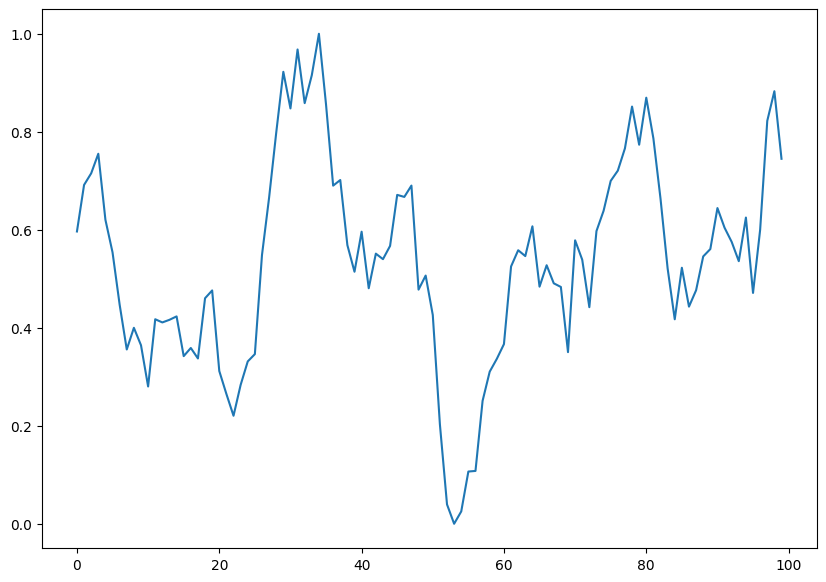

In [28]:
# 感情曲線の表示
plot_score(neko_score, save=True, file_name='neko.pdf')

### (2) 坊ちゃん

In [29]:
bochan_score = analyze_work(f'{CARD_DIR}/000148/files/edit/752_ruby_2438.txt')
len(bochan_score)

100

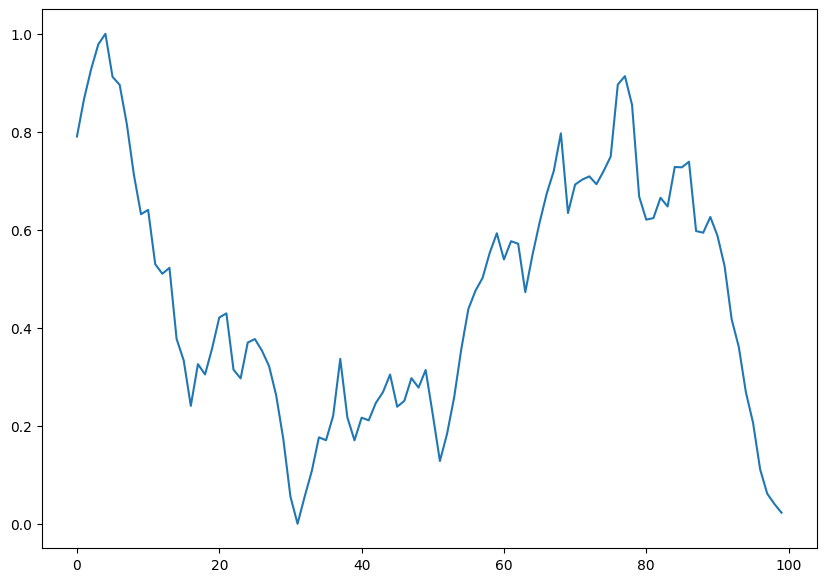

In [30]:
plot_score(bochan_score, save=True, file_name='bochan.pdf')

### (3) こころ

In [31]:
kokoro_score = analyze_work(f'{CARD_DIR}/000148/files/edit/773_ruby_5968.txt')
len(kokoro_score)

100

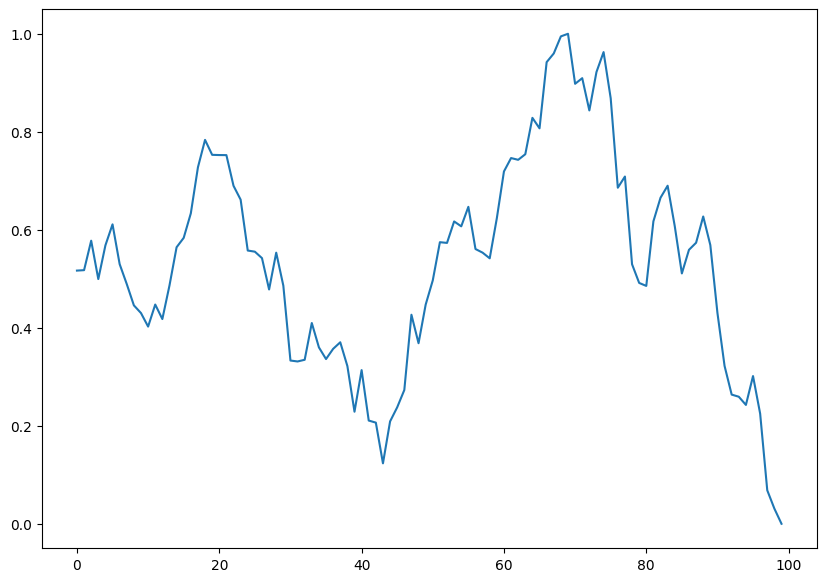

In [32]:
plot_score(kokoro_score, save=True, file_name='kokoro.pdf')

### (4)先行研究で取り上げられていた作品

#### (4)-1. 押絵と旅する男

In [33]:
oshie_score = analyze_work(f'{CARD_DIR}/001779/files/edit/56645_ruby_58194.txt', force=True)
len(oshie_score)

100%|██████████| 323/323 [01:19<00:00,  4.06it/s]


100

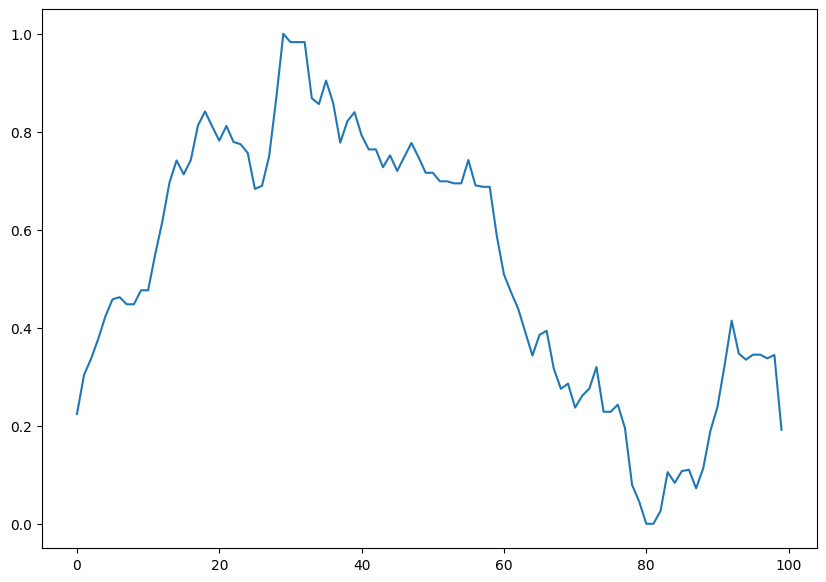

In [34]:
plot_score(oshie_score, save=True, file_name='oshie.pdf')

#### (4)-2. フランダースの犬

In [35]:
nero_score = analyze_work(f'{CARD_DIR}/001044/files/edit/4880_ruby_13757.txt')
len(nero_score)

100

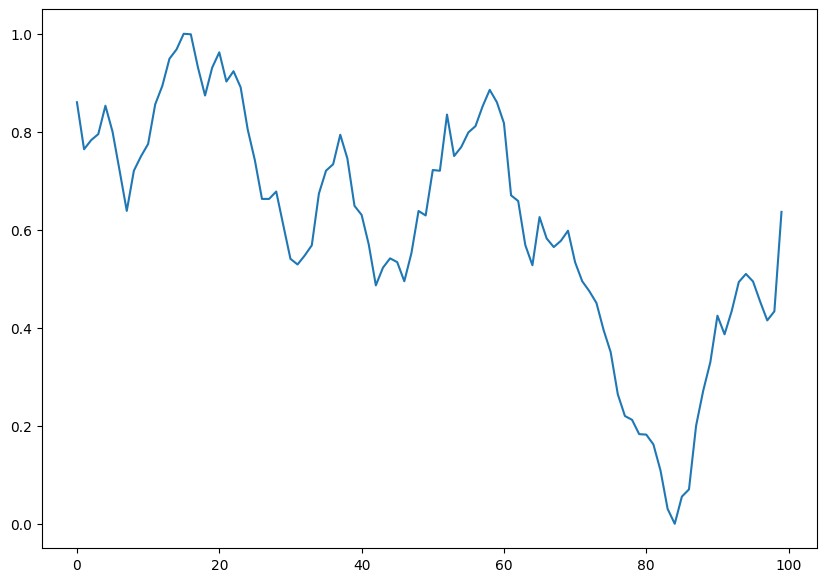

In [36]:
plot_score(nero_score, save=True, file_name='nero.pdf')

#### (4)-3. 銀河鉄道の夜

In [37]:
ginga_score = analyze_work(f'{CARD_DIR}/000081/files/edit/456_ruby_145.txt')
len(ginga_score)

100

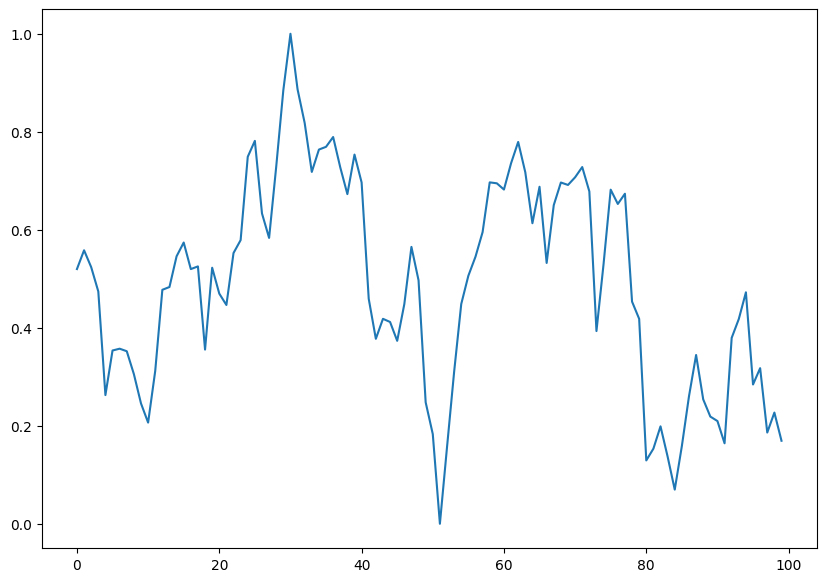

In [38]:
plot_score(ginga_score, save=True, file_name='ginga.pdf')